In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import  hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict

In [2]:
def alpha_sweep(SC, ref_path, alphas, max_depth, verbose=False, prune=False, eps=1e-4):
    paths = []

    data_arr = np.zeros((len(alphas), 3))
    ref_proj = ref_path.proj[-1]
        
    for i, alpha in tqdm(enumerate(alphas)): 
        path_i, _, _, visited_i = k_rollout(SC, ref_path, alpha, max_depth, prune, eps, verbose)
        proj_diff_i = path_i.proj_diff(ref_path, False)
        len_i = path_i.weight
        data_arr[i,:] = proj_diff_i, len_i, visited_i
        paths.append(path_i)

    proj_diffs, path_lens, num_visited = data_arr[:,0], data_arr[:,1], data_arr[:,2]

    return paths, path_lens, proj_diffs, num_visited

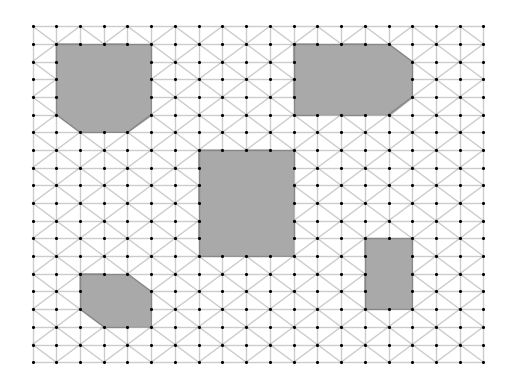

In [3]:
num_rows = 20
top, left, height, width = 1, -1, 2, 2

# Initialize Simplicial Complex (SC)
SC = SimplicialComplex(num_rows, False, False, True)

holes_info = [(-0.78, -0.5, 0.3, 0.2), (-0.8, 0.8, 0.25, 0.4), (-0.2,0.2,0.3,0.5), (0.2,0.8,0.4,0.3), (0.5, -0.3, 0.15, 0.3)]
hole_pts = [rect_hole(*hole_pt) for hole_pt in holes_info]

for hole_pt in hole_pts:
    sorted_pts, polar_ang, polar_mag = get_polygon_order(hole_pt)
    hole_nodes = poly_hole(SC, sorted_pts)
    SC.del_simplices({0:hole_nodes})

plot_sc(SC)

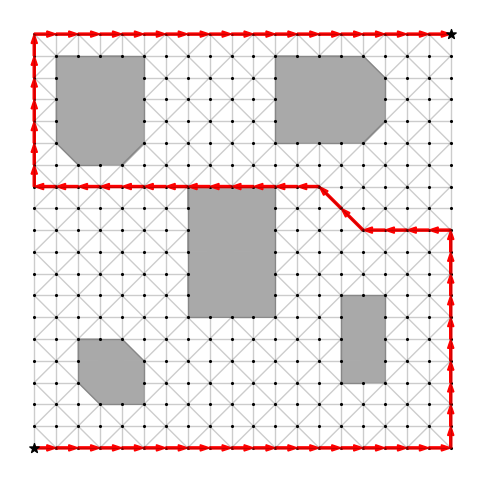

In [4]:
coords = np.array([(-1,-1), (1,-1), (1, 0), (-1,0.3), (-1,1), (1,1)])
ref_path = path_from_coords(SC, coords)
plot_path(SC, [ref_path], 'red', 'path')

In [5]:
alphas = np.linspace(0, 3.5, 30)
folder = "../exp1_data"

In [ ]:
# Base heuristic 
paths_reg, path_lens_reg, proj_diffs_reg, num_visited_reg = alpha_sweep(SC, ref_path, alphas, 0, False, False)
np.savez(f"{folder}/exp1_data_base",  paths=paths_reg, lengths=path_lens_reg, proj_diffs=proj_diffs_reg, num_visited=num_visited_reg)

In [ ]:
# One step lookahead
paths_roll, path_lens_roll, proj_diffs_roll, num_visited_roll = alpha_sweep(SC, ref_path, alphas, 1, False, False)
np.savez(f"{folder}/exp1_data_roll",  paths=paths_roll, lengths=path_lens_roll, proj_diffs=proj_diffs_roll, num_visited=num_visited_roll)

In [ ]:
# One step lookahead w/ prune
paths_prune, path_lens_prune, proj_diffs_prune, num_visited_prune = alpha_sweep(SC, ref_path, alphas, 1, False, True)
np.savez(f"{folder}/exp1_data_prune", paths=paths_prune, lengths=path_lens_prune, proj_diffs=proj_diffs_prune, num_visited=num_visited_prune)

In [7]:
# Bhattacharya

eps = 1e-7
start, end = ref_path[0], ref_path[-1]
path_bhat, other_paths_bhat, num_visited_bhat = bhattacharya(SC, ref_path, start, end, eps, True, True)
np.savez(f"{folder}/exp1_data_bhat",  path=path_bhat, others=other_paths_bhat, num_visited=num_visited_bhat)

Found path with projection difference = 3.244343144 and length  = 3.14
Found path with projection difference = 4.0236669173 and length  = 3.26
Found path with projection difference = 3.3298716568 and length  = 3.32
Found path with projection difference = 3.6037320977 and length  = 3.38
Found path with projection difference = 3.8303330312 and length  = 3.38
Found path with projection difference = 3.0938720139 and length  = 3.45
Found path with projection difference = 2.6051132784 and length  = 3.57
Found path with projection difference = 2.8390807118 and length  = 3.63
Found path with projection difference = 3.0406076154 and length  = 3.82
Found path with projection difference = 2.3469426517 and length  = 3.88
Found path with projection difference = 3.2503657943 and length  = 4.05
Found path with projection difference = 3.5916340449 and length  = 4.28
Found path with projection difference = 3.2991565244 and length  = 4.29
Found path with projection difference = 4.7480032713 and length  

/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Process and plot 

In [6]:
data_reg = np.load(f"{folder}/exp1_data_base.npz", allow_pickle=True)
paths_reg, path_lens_reg, proj_diffs_reg, num_visited_reg = data_reg["paths"], data_reg["lengths"], data_reg["proj_diffs"], data_reg["num_visited"] 
data_roll = np.load(f"{folder}/exp1_data_roll.npz", allow_pickle=True)
paths_roll, path_lens_roll, proj_diffs_roll, num_visited_roll = data_roll["paths"], data_roll["lengths"], data_roll["proj_diffs"], data_roll["num_visited"] 
data_prune = np.load(f"{folder}/exp1_data_prune.npz", allow_pickle=True)
paths_prune, path_lens_prune, proj_diffs_prune, num_visited_prune = data_prune["paths"], data_prune["lengths"], data_prune["proj_diffs"], data_prune["num_visited"] 
data_bhat = np.load(f"{folder}/exp1_data_bhat.npz", allow_pickle=True)
path_bhat, other_paths_bhat, num_visited_bhat = Path(SC, data_bhat["path"]), data_bhat["others"], data_bhat["num_visited"]

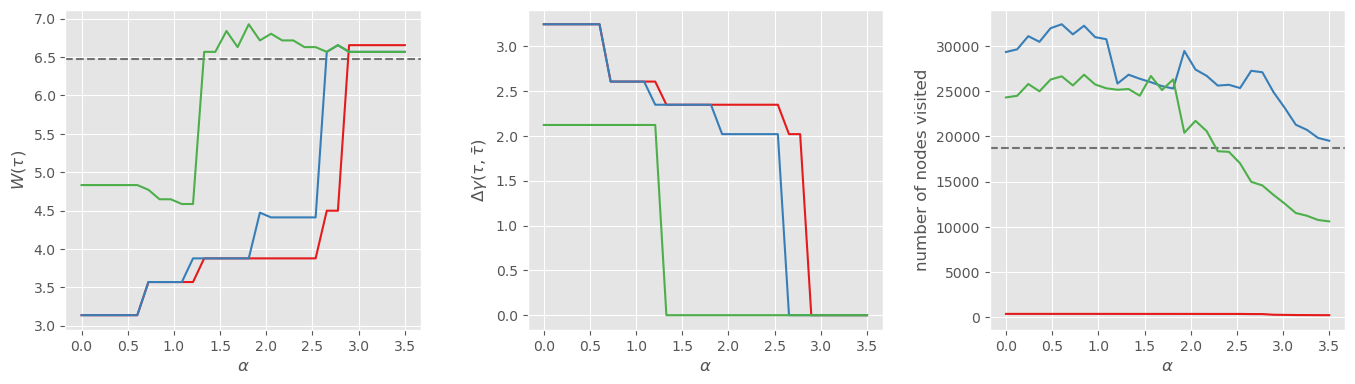

In [7]:
matplotlib.style.use('ggplot')
plt.rcParams['text.usetex'] = False

plt.figure(0, (16, 4))

colors = [plt.cm.Set1(i) for i in range(20)]


ax1 = plt.subplot(133)
plt.axhline(num_visited_bhat, color='k', linestyle='dashed', alpha=0.5, label="Bhattacharya et al")
plt.plot(alphas, num_visited_reg, label="Base", color=colors[0])
plt.plot(alphas, num_visited_roll, label="Rollout", color=colors[1])
plt.plot(alphas, num_visited_prune, label="Pruned Rollout", color=colors[2])
# plt.legend()
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel(r"number of nodes visited")

ax2 = plt.subplot(132)
plt.plot(alphas, proj_diffs_reg, label="Base", color=colors[0])
plt.plot(alphas, proj_diffs_roll, label="Rollout", color=colors[1])
plt.plot(alphas, proj_diffs_prune, label="Pruned Rollout", color=colors[2])
# plt.legend()
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel(r"$\Delta \gamma(\tau, \bar{\tau})$")

ax3 = plt.subplot(131)
plt.axhline(path_bhat.weight, color='k', linestyle='dashed', alpha=0.5, label="Bhattacharya et al")
plt.plot(alphas, path_lens_reg, label="Base", color=colors[0])
plt.plot(alphas, path_lens_roll, label="Rollout", color=colors[1])
plt.plot(alphas, path_lens_prune, label="Pruned Rollout", color=colors[2])
# plt.legend()
ax3.set_xlabel(r"$\alpha$")
ax3.set_ylabel(r"$W(\tau)$")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

plt.savefig(f"{folder}/exp1_alpha_sweep.png", dpi=300, bbox_inches='tight', format='png', pad_inches=0,)

In [13]:
def get_transitions(path_arr, ref_proj):
    proj_arr = np.array([np.linalg.norm(x.proj - ref_proj, 2) for x in path_arr])
    proj_grad = proj_arr[:-1] - proj_arr[1:]
    transitions = np.where(proj_grad > 0)[0] + 1
    return np.append([0], transitions)

def identify_class(heuristic_paths, bhat_paths, eps=1e-5):
    corresponding_shortest = []
    for i, path_i in enumerate(heuristic_paths):
        for j, path_j in enumerate(bhat_paths):
            if almost_equal(path_i.proj, path_j.proj, eps):
                corresponding_shortest.append(path_j)
                break
    return corresponding_shortest

ref_proj = ref_path.proj

trans_reg = get_transitions(paths_reg, ref_proj)
trans_roll = get_transitions(paths_roll, ref_proj)
trans_prune = get_transitions(paths_prune, ref_proj)

def get_best_paths(paths, bounds):
    best_paths = []
    path_lens = [x.weight for x in paths]
    for i in range(len(bounds)):
        left = bounds[i]
        right = len(paths) if i == len(bounds) - 1 else bounds[i+1]
        sub_arr = path_lens[left:right]
        best_path = paths[left + np.argmin(sub_arr)]
        best_paths.append(best_path)

    return best_paths

def assign_colors_to_paths(paths1, paths2, paths3, colors, decimals):
    paths = paths1 + paths2 + paths3
    color_dict = {}
    k = 1
    assigned_colors = [None] * len(paths)
    for i, x in enumerate(paths):
        proj_x = tuple(np.round(x.proj, decimals))
        if proj_x in color_dict:
            assigned_colors[i] = color_dict[proj_x]
        if proj_x not in color_dict:
            k += 1
            color_dict[proj_x] = colors[k]
            assigned_colors[i] = colors[k]

    n1, n2, n3 = len(paths1), len(paths2), len(paths3)

    path1_colors = colors[:2] + assigned_colors[:n1]
    path2_colors = colors[:2] + assigned_colors[n1:n1+n2]
    path3_colors = colors[:2] + assigned_colors[n1+n2:]

    return path1_colors, path2_colors, path3_colors, color_dict

paths_to_plot_reg = get_best_paths(paths_reg, trans_reg)
paths_to_plot_roll = get_best_paths(paths_roll, trans_roll)
paths_to_plot_prune = get_best_paths(paths_prune, trans_prune)

decimals=3

colors_reg, colors_roll, colors_prune, color_dict = assign_colors_to_paths(paths_to_plot_reg, paths_to_plot_roll, paths_to_plot_prune, colors, decimals)


<Figure size 1600x400 with 0 Axes>

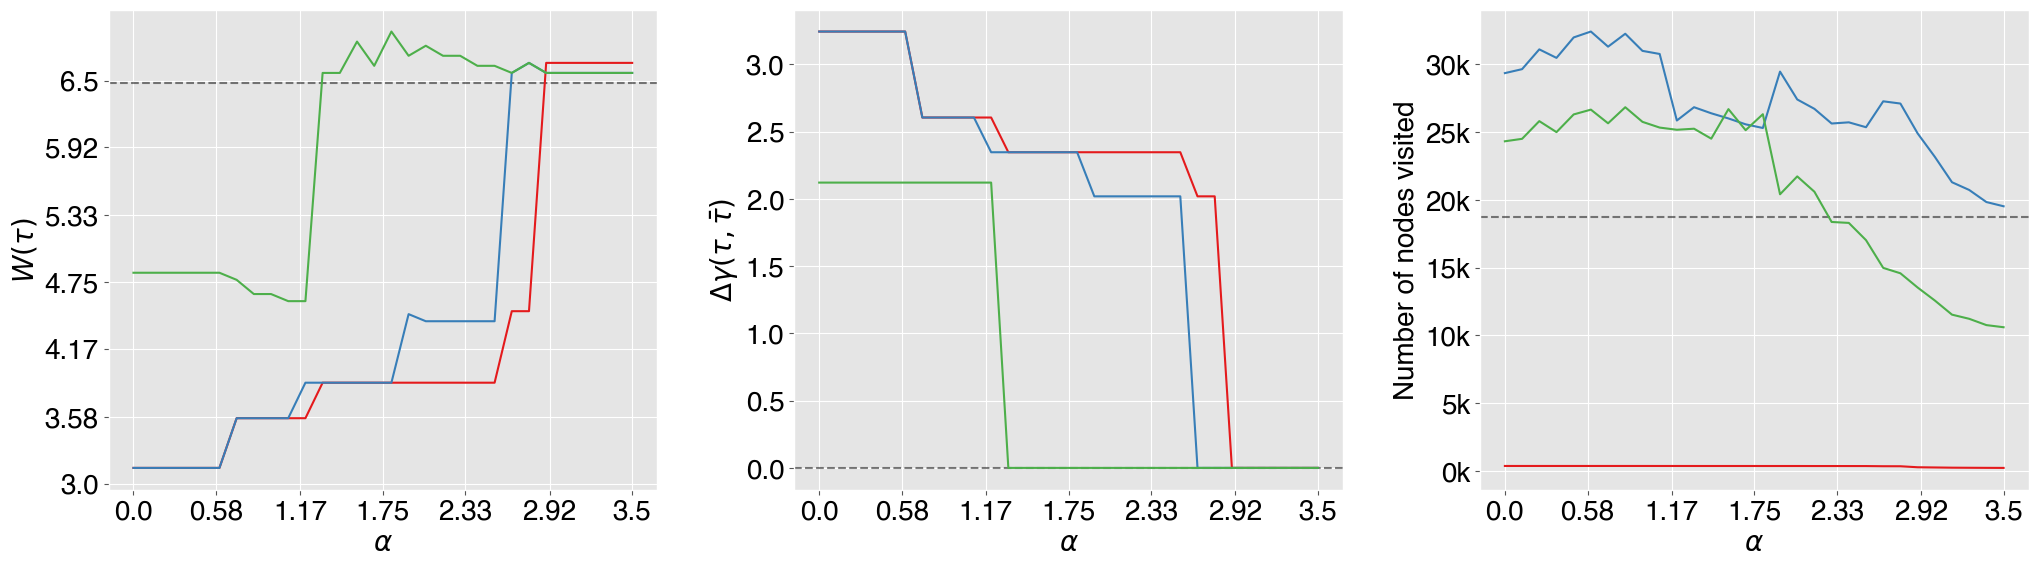

In [14]:
font = {'family': 'Helvetica',
    'color':  'black',
    'weight': 'normal',
    'size': 20}


matplotlib.style.use('ggplot')
plt.rcParams['text.usetex'] = False
plt.figure(0, (16, 4))
fig, axes = plt.subplots(1, 3, figsize=(24,6))

ax1 = plt.subplot(131)
ax1.axhline(path_bhat.weight, color='k', linestyle='dashed', alpha=0.5, label="Bhattacharya et al")
for i, path in enumerate(list(other_paths_bhat) + [path_bhat]):
    for x in list(paths_reg) + list(paths_roll) + list(paths_prune):
        proj_comp = x.proj_diff(path, False)        
        if proj_comp == 0:
            color = color_dict[tuple(np.round(x.edge_projections[-1], decimals))]
            proj_diff = path.proj_diff(ref_path, False)
            ax1.axhline(path.weight, color=color, linestyle='dashed', alpha=0.7)
            break
ax1.plot(alphas, path_lens_reg, label="H*", color=colors[0])
ax1.plot(alphas, path_lens_roll, label="RH*", color=colors[1])
ax1.plot(alphas, path_lens_prune, label="PRH*", color=colors[2])
# ax1.legend(loc='upper left', fontsize=16)
ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_ylabel(r"$W(\tau)$", fontdict=font)

ax2 = plt.subplot(132)
ax2.axhline(0, color='k', linestyle='dashed', alpha=0.5, label="Bhattacharya et al")
for path in list(other_paths_bhat) + [path_bhat]:
    for x in list(paths_reg) + list(paths_roll) + list(paths_prune):
        proj_comp = path.proj_diff(x, False)
        if proj_comp == 0:
            color = color_dict[tuple(np.round(x.edge_projections[-1], decimals))]
            proj_diff = path.proj_diff(ref_path, False)
            ax2.axhline(proj_diff, color=color, linestyle='dashed', alpha=0.7)
            break
# ax2.axvline(1.171052335161985, color='k', linestyle=':', alpha=0.2)
ax2.plot(alphas, proj_diffs_reg, label="H*", color=colors[0])
ax2.plot(alphas, proj_diffs_roll, label="RH*", color=colors[1])
ax2.plot(alphas, proj_diffs_prune, label="PRH*", color=colors[2])
# ax2.legend(loc='upper left', fontsize=16)
ax2.set_xlabel(r"$\alpha$", fontdict=font)
ax2.set_ylabel(r"$\Delta \gamma(\tau, \bar{\tau})$", fontdict=font)

ax3 = plt.subplot(133)
plt.axhline(num_visited_bhat, color='k', linestyle='dashed', alpha=0.5, label="Bhattacharya et al")
plt.plot(alphas, num_visited_reg, label="H*", color=colors[0])
plt.plot(alphas, num_visited_roll, label="RH*", color=colors[1])
plt.plot(alphas, num_visited_prune, label="PRH*", color=colors[2])
# ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel(r"Number of nodes visited", fontdict=font)

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)

xticks = np.round(np.linspace(0,3.5, 7), 2)
y1ticks = np.round(np.linspace(3, 6.5, 7), 2)
y2ticks = np.round(np.linspace(0, 3, 7), 2)
y3ticks = np.round(np.linspace(0, 30000, 7))

ax1.set_xticks(xticks)
ax1.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax1.set_yticks(y1ticks)
ax1.set_yticklabels([str(i) for i in y1ticks], fontdict=font)

ax2.set_xticks(xticks)
ax2.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax2.set_yticks(y2ticks)
ax2.set_yticklabels([str(np.round(i, 1)) for i in y2ticks], fontdict=font)

ax3.set_xticks(xticks)
ax3.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax3.set_yticks(y3ticks)
ax3.set_yticklabels([str(int(i/1000))+"k" for i in y3ticks], fontdict=font)

plt.savefig(f"{folder}/exp1_alpha_sweep_alt.png", dpi=300, bbox_inches='tight', format='png', pad_inches=0,)